In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### File reading

          0         1         2
0  0.912742  1.719443  1.606405
1  0.313207  1.769782  1.628300
2  1.423678 -0.713694 -0.594431
3 -0.066379  2.153243  1.963148
4  1.036332  0.658611  0.642875


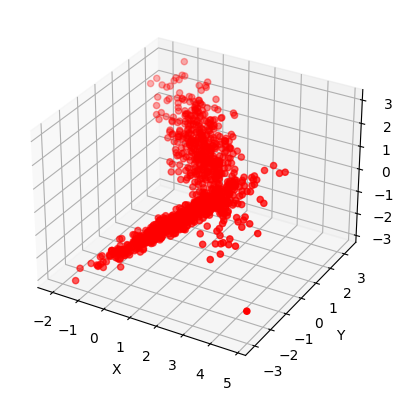

In [29]:
# read txt file
file = pd.read_csv('alvbercau_alvgonfri_dataset.txt', sep=" ", header=None)

# convert to dataframe in order to use pandas methods if needed
df = pd.DataFrame(file)

# show the first 5 rows
print(df.head())

# visualize the data with a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0], df[1], df[2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# convert dataframe to numpy array
X = df.values


### K-means

In [30]:
def kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
    labels = kmeans.predict(data)
    return labels

### Clustering method

In [31]:
def clustering(data, algorithm, hyperparameters):
    if algorithm == 'birch':
        return None
    elif algorithm == 'dbscan':
        return None
    elif algorithm == 'kmeans':
        return kmeans(data, hyperparameters.get('n_clusters'))
    elif algorithm == 'mini_batch_kmeans':
        return None 
    elif algorithm == 'mean_shift':
        return None
    elif algorithm == 'optics':
        return None
    elif algorithm == 'spectral_clustering':
        return None
    elif algorithm == 'mixture_of_gaussians':
        return None
    elif algorithm == 'partition_around_medoids':
        return None
    elif algorithm == 'upgma':
        return None       
    else:
        print("Not valid algorithm")

### Visualizing a labelled dataset

In [32]:
def visualize_labelled_dataset(data, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=labels, marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

### Testing methods

[0 0 1 0 1 1 1 1 2 1 2 0 2 2 2 0 0 0 1 2 0 1 2 2 1 0 0 2 0 0 2 0 1 1 1 1 1
 2 0 1 1 1 0 1 1 2 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 0 1 0 2 2 2 0 0 1 2 2
 2 0 1 0 0 1 0 0 0 1 1 0 2 2 1 2 0 2 0 2 2 1 1 0 0 0 1 2 1 1 0 1 0 2 0 2 1
 0 2 1 1 1 0 2 0 2 0 1 1 1 1 0 1 2 1 2 1 1 1 1 2 2 1 2 0 0 0 2 0 2 2 1 0 2
 1 1 2 2 0 0 2 1 2 1 2 1 1 2 0 1 0 1 2 1 1 1 2 2 1 2 0 2 2 0 2 1 2 0 1 2 1
 2 0 1 1 0 1 0 0 1 2 2 2 0 1 0 0 0 0 2 2 0 1 1 0 2 2 1 0 2 2 1 1 0 2 2 1 2
 0 1 2 1 2 1 1 1 1 0 1 1 2 0 0 0 1 2 0 0 2 2 2 1 1 1 1 1 0 0 1 0 1 1 2 0 0
 0 1 1 0 2 0 2 1 2 0 1 2 1 2 2 2 1 1 0 1 0 2 1 0 2 0 1 0 2 0 1 1 1 2 1 1 2
 2 2 0 2 1 1 0 1 1 2 1 2 0 0 1 1 2 2 1 2 1 1 1 2 2 0 1 2 0 1 0 2 1 2 0 2 1
 0 1 2 2 1 1 0 2 1 2 1 1 1 2 0 1 0 1 1 2 1 1 1 1 0 2 0 1 1 1 0 0 1 1 1 0 2
 2 1 2 1 1 2 2 0 1 1 1 2 0 1 1 0 2 0 1 2 2 1 2 1 2 2 0 0 1 1 1 2 1 1 0 1 1
 0 1 2 0 2 0 0 1 0 1 0 2 1 1 1 2 1 0 2 1 0 0 1 1 0 2 2 2 1 0 1 0 1 2 1 0 2
 2 2 0 2 1 1 0 2 0 2 0 0 2 2 2 1 0 0 1 0 2 2 0 0 2 1 1 2 2 2 1 0 0 1 1 1 0
 2 2 2 0 2 2 2 1 2 2 0 1 

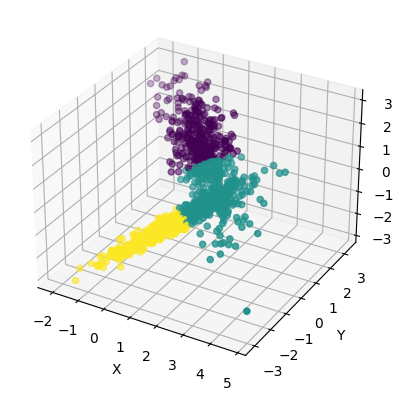

In [33]:
# kmeans with 3 clusters
labels = clustering(X, 'kmeans', {'n_clusters': 3})
print(labels)
visualize_labelled_dataset(X, labels)